In [16]:
import pandas as pd
import numpy as np

In [17]:
X = pd.read_csv('../data/USA/LC/X_train.csv.gz')
y = pd.read_csv('../data/USA/LC/y_train.csv')
y = y.loan_status_bin  #as series

In [18]:
X['grade']=X['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X['annual_inc_log'] = X['annual_inc'].apply(np.log)
X.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc_log
0,14400.0,60 months,12.49,323.90,2,7 years,MORTGAGE,40000.0,Not Verified,debt_consolidation,...,16.08,0.0,770.0,0.0,13.0,0.0,7771.0,13.8,30.0,10.596635
1,9600.0,36 months,13.99,328.06,3,6 years,RENT,60000.0,Verified,debt_consolidation,...,16.54,0.0,675.0,1.0,12.0,0.0,10965.0,87.7,31.0,11.002100
2,11500.0,60 months,15.61,277.29,3,10+ years,RENT,34000.0,Source Verified,debt_consolidation,...,17.08,0.0,685.0,0.0,7.0,0.0,9321.0,48.8,8.0,10.434116
3,10000.0,36 months,11.49,329.72,2,10+ years,MORTGAGE,49000.0,Source Verified,credit_card,...,13.92,1.0,680.0,1.0,9.0,0.0,5984.0,48.3,34.0,10.799576
4,3500.0,36 months,19.03,128.35,4,10+ years,MORTGAGE,40000.0,Source Verified,debt_consolidation,...,24.33,0.0,660.0,0.0,7.0,1.0,9254.0,54.1,16.0,10.596635


In [19]:
import joblib
pipe_lss = joblib.load('../data/USA/LC/state_lss.pkl')

In [20]:
df_state = pd.read_csv('../data/USA/State/state_data.csv')
df_state['state_var'] = pipe_lss.predict(df_state)
df_state.head(4)

,N,State_Name,Code,GDP_PC,gini,cost_living,hdi,pbf,ccdebt,spi,unemp,state_var
0,1,Alabama,AL,45219,0.4847,89.87,4.04,519,7105,33.60,3.9,0.069859
1,2,Alaska,AK,73205,0.4081,122.88,5.06,56,13048,43.77,6.5,-0.013420
2,3,Arizona,AZ,48055,0.4713,97.66,4.89,305,7100,45.43,4.7,-0.000735
3,4,Arkansas,AR,42454,0.4719,89.17,3.91,374,6747,32.10,3.6,0.081117


In [21]:
state_dict = {}
for s,x in zip(df_state.Code,df_state.state_var):
    state_dict[s] = x 

In [22]:
state_mcoefs = []
for s in X.addr_state:
    state_mcoefs.append(state_dict[s])
X['m_coefs'] = state_mcoefs 

In [23]:
used_vars = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'purpose', 'm_coefs', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from transformers import ColumnSelectTransformer, EncoderTransformer

cst = ColumnSelectTransformer(used_vars)
sce = EncoderTransformer()
sc = MinMaxScaler()
clf = LogisticRegression(penalty='l1', C=0.01, random_state=0, solver='liblinear')

pipe_lr = Pipeline([('colsel', cst), ('encoder', sce), ('scaler', sc), ('clf', clf)])

In [25]:
pipe_lr.fit(X, y)

Pipeline(memory=None,
     steps=[('colsel', ColumnSelectTransformer(col_names=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc_log', 'verification_status', 'purpose', 'm_coefs', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', '...nalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [26]:
X_t = pd.read_csv('../data/USA/LC/X_test.csv')
y_t = pd.read_csv('../data/USA/LC/y_test.csv')
y_t = y_t.loan_status_bin  #as series

In [27]:
X_t['grade']=X_t['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X_t['annual_inc_log'] = X_t['annual_inc'].apply(np.log)

In [28]:
tstate_mcoefs = []
for s in X_t.addr_state:
    tstate_mcoefs.append(state_dict[s])
X_t['m_coefs'] = tstate_mcoefs 

In [29]:
test_probas = pipe_lr.predict_proba(X_t)[:,1]

ROC-AUC-score:  0.7109288785332558


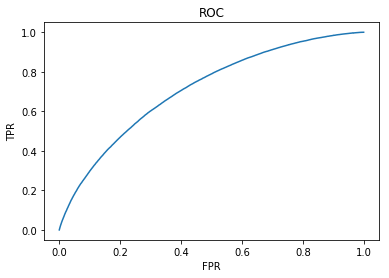

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, tresholds = roc_curve(y_t, test_probas)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_t, test_probas))

0.7129 original <br>
0.7109 original wout state data + state econ y social model <br>
0.7107 original wout state data <br>
0.7084 wout american <br>
0.7062 wout american and state data <br>